<h1 style="background-color:Tomato;">K-Nearest Neighbour Exercises

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

import prepare
import acquire

import warnings
warnings.filterwarnings("ignore")

from sklearn.neighbors import KNeighborsClassifier

from pydataset import data

### 1 / Fit a K-Nearest Neighbors classifier to your training sample and transform (i.e, make predictions on the training sample).
Use Titanic.

In [2]:
tati = pd.read_csv('titanic.csv')
tati.head()

,Unnamed: 0,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,0,3,male,22.0,1,0,7.2500,S,Third,NaN,Southampton,0
1,1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0
2,2,2,1,3,female,26.0,0,0,7.9250,S,Third,NaN,Southampton,1
3,3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0
4,4,4,0,3,male,35.0,0,0,8.0500,S,Third,NaN,Southampton,1


In [3]:
to_drop = ['deck', 'Unnamed: 0', 'age', 'embarked', 'passenger_id', 'class']

# indicating which unnecessary or superfluous columns to drop

In [4]:
tati.drop(columns = to_drop, inplace = True)

# dropping unnecessary or superfluous columns 

In [5]:
tati = tati.dropna()
tati.info()

#  drop rows with nulls

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     889 non-null    int64  
 1   pclass       889 non-null    int64  
 2   sex          889 non-null    object 
 3   sibsp        889 non-null    int64  
 4   parch        889 non-null    int64  
 5   fare         889 non-null    float64
 6   embark_town  889 non-null    object 
 7   alone        889 non-null    int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 62.5+ KB


In [6]:
# baseline for survival is to die (ie, ['survived'] == '0').

tati[tati.survived == 0]

tati.head()

,survived,pclass,sex,sibsp,parch,fare,embark_town,alone
0,0,3,male,1,0,7.2500,Southampton,0
1,1,1,female,1,0,71.2833,Cherbourg,0
2,1,3,female,0,0,7.9250,Southampton,1
3,1,1,female,1,0,53.1000,Southampton,0
4,0,3,male,0,0,8.0500,Southampton,1


In [7]:
tati['survival_baseline'] = 0


In [8]:
# Boolean baseline (T = 1, F = 0)

bline = (tati['survival_baseline'] == tati['survived']).mean()

print(f"The baseline survival rate is {bline}.")

The baseline survival rate is 0.6175478065241845.


In [9]:
# creating dummies in order to help machine learning

tatdum = pd.get_dummies(tati[['embark_town', 'sex']], drop_first = True)


In [10]:
# now that we have the DF and the dummies, use concatenation to join the two :

pd.concat([tati, tatdum], axis = 1)

# assigning it a variable for permanence

tati = pd.concat([tati, tatdum], axis = 1)
tati.head()

,survived,pclass,sex,sibsp,parch,fare,embark_town,alone,survival_baseline,embark_town_Queenstown,embark_town_Southampton,sex_male
0,0,3,male,1,0,7.2500,Southampton,0,0,0,1,1
1,1,1,female,1,0,71.2833,Cherbourg,0,0,0,0,0
2,1,3,female,0,0,7.9250,Southampton,1,0,0,1,0
3,1,1,female,1,0,53.1000,Southampton,0,0,0,1,0
4,0,3,male,0,0,8.0500,Southampton,1,0,0,1,1


In [11]:
# dropping columns for machine learning purposes (don't do this for exploration purposes)

tati = tati.drop(columns = ['embark_town', 'sex'], axis = 1)
tati.columns

Index(['survived', 'pclass', 'sibsp', 'parch', 'fare', 'alone',
       'survival_baseline', 'embark_town_Queenstown',
       'embark_town_Southampton', 'sex_male'],
      dtype='object')

In [12]:
# setting the 'survived' column to Boolean T / F
tati['survived'] = np.where(tati['survived'] == True, '1', '0')

In [13]:
tati['survived']

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: survived, Length: 889, dtype: object

In [14]:
def train_val_test(df, target, seed = 23):
    
    train, val_test = train_test_split(df, train_size = 0.7, 
                                       random_state = seed, 
                                       stratify = df[target])
    
    val, test = train_test_split(val_test, train_size = 0.5, 
                                 random_state = seed, 
                                 stratify = val_test[target])
    
    return train, val, test

## function to train, validate, test data

In [15]:
train, val, test  = train_val_test(tati, 'survived')

train.shape, val.shape, test.shape

# returning the data shapes / sizes to be trained, validated, tested

((622, 10), (133, 10), (134, 10))

In [16]:
# split train, val, test into X_train, X_val, X_test (feature DF, exludes var 'survived') and y-train, etc

# y_train is only our target

# X_train is everything except for 'survived'

X_train = train.drop(columns = ['survived'])
y_train = train['survived']


X_val = val.drop(columns = ['survived'])
y_val = val['survived']


X_test = test.drop(columns = ['survived'])
y_test = test['survived']

In [17]:
knn = KNeighborsClassifier(n_neighbors = 5)

# has 5 neighbours : will find the 5 observations nearest to the new datapoint and check their class
# 5 is the default

In [18]:
knn.fit(X_train, y_train)

# training the KNN model

KNeighborsClassifier()

In [19]:
# this tells us how accurate the model is. 

knn.score(X_train, y_train)

# we're predicting on the features (X_train, the first variable), and
# comparing to the actual labels (the 2nd variable, y_train)

0.8295819935691319

In [20]:
knn.score(X_val, y_val)

# the divide btwn the train & val scores is quite high, about 12pc

0.706766917293233

In [21]:
# ## make a loopx

# nº_neighbours = []
# train_accuracy = []
# validation_accuracy = []

# # the empty lists can be filled each time going through the loop

# for i in range(1, 99, 5):
    
#     knn = KNeighborsClassifier(n_neighbors = i)
    
#     knn.fit(X_train, y_train)    # training the KNN model
    
#     nº_neighbours.append(i)
    
#     train_accuracy.append(knn.score(X_train, y_train))
#             # this tells us how accurate the training model
    
#     validation_accuracy.append(knn.score(X_val, y_val))
#             # this tells us how accurate the validation model
        

In [22]:
# # making a DF to visualise the above loop

# knnmetrix = pd.DataFrame({'neighbours' : nº_neighbours,
# #                          'train_accuracy' : train_accuracy,
#                          'validation_accuracy' : validation_accuracy
#                          })



# knnmetrix 

In [23]:
knn

KNeighborsClassifier()

**Observations :**
 - The 'knnmetrix' DF shows that with more neighbours, the train accuracy becomes lower ;
 - Seven neighbours seems to be the best here, because the 'train_accuracy' is similar to 5 neighbours (about 82pc), but 'validation_accuracy' at 7 neighbours is higher than at 5 neighbours (72pc vs 70pc).


### 2 / Evaluate your results using the model score, confusion matrix, and classification report.

In [24]:
knn.score(X_train, y_train)

# model score for the train dataset

0.8295819935691319

In [25]:
knn.score(X_val, y_val)

# model score for the validation dataset

0.706766917293233

In [26]:
knn.score(X_test, y_test)

# model score for the test dataset

0.7238805970149254

**Observations :**  
    - The model score for the training dataset is 79.1pc, for validation dataset 67.67pc, for test dataset 73.88pc.  
    - 12pc gap between training & validation is too large.  
    - Still, the rates are higher than the baseline (61pc).  
    - I now understand that, in the future, running .score(X_test, y_test) should wait until later in the train-val-test process, after a model had been chosen based on training & validation results.

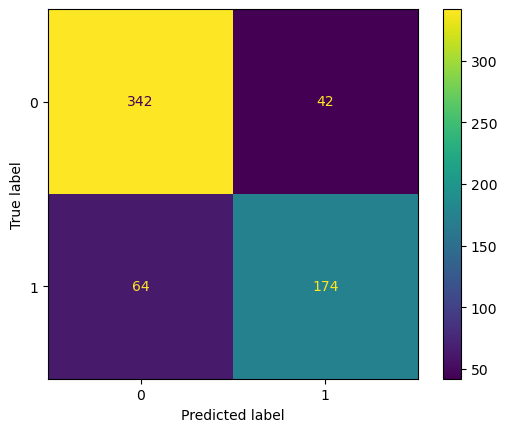

In [27]:
## making a confusion matrix for knn

plot_confusion_matrix(knn, X_train, y_train)


In [60]:
# making y predictions on X_train dataset,
# to allow for the confusion_matrix to be realised

y_preds = knn.predict(X_train)

In [59]:
# # making y predictions on X_train dataset,
# # to allow for the confusion_matrix to be realised

# y_preds = knn.predict(X_train)

# # returning the confusion matrix as an array

# confu = confusion_matrix(y_preds, y_train)
# confu

# # unravelling the confusion matrix & assigning each value to a variable

# TN, FP, FN, TP = confu.ravel()

# TN, FP, FN, TP

# print(classification_report(y_train, y_preds))

# # classification report on the training dataset

(342, 64, 42, 174)

In [67]:
# returning the confusion matrix as an array

confu = confusion_matrix(y_preds, y_train)
confu

array([[342,  64],
       [ 42, 174]])

In [31]:
# unravelling the confusion matrix & assigning each value to a variable

TN, FP, FN, TP = confu.ravel()

TN, FP, FN, TP

(342, 64, 42, 174)

In [69]:
classification_report(y_train, y_preds)



print(classification_report(y_train, y_preds))

# classification report on the training dataset
# classification report on the training dataset

              precision    recall  f1-score   support

           0       0.84      0.89      0.87       384
           1       0.81      0.73      0.77       238

    accuracy                           0.83       622
   macro avg       0.82      0.81      0.82       622
weighted avg       0.83      0.83      0.83       622



### 3 /  Print and clearly label the following : 
Accuracy, true positive rate / recall, false positive rate, true negative rate, false negative rate, precision, f1-score and support.  

In [33]:
# Accuracy

print(f'The accuracy is {sklearn.metrics.accuracy_score(y_train, y_preds)}.')


The accuracy is 0.8295819935691319.


In [34]:
# sensitivity / true positive rate / recall

print(f'The recall is {sklearn.metrics.recall_score(y_train, y_preds, average = None)}.')

The recall is [0.890625   0.73109244].


In [35]:
# false negative rate

print(f'The false negative rate is {round(FN / (TP + FN), 4)}).')

The false negative rate is 0.1944).


In [36]:
# precision / PPV

print(f'The precision rate is {sklearn.metrics.precision_score(y_train, y_preds, average = None)}.')

The precision rate is [0.84236453 0.80555556].


In [37]:
# support

support_pos = TP + FN ## positive cases
support_neg = FP + TN ## negative cases

support_pos, support_neg, y_train.value_counts()

(216,
 406,
 0    384
 1    238
 Name: survived, dtype: int64)

In [38]:
# f1 score

print(f'The f1 score is {sklearn.metrics.f1_score(y_train, y_preds, average = None)}.')

The f1 score is [0.86582278 0.76651982].


In [39]:
# support

print(f'The support is {sklearn.metrics.precision_recall_fscore_support(y_train, y_preds, average = None)}.')

The support is (array([0.84236453, 0.80555556]), array([0.890625  , 0.73109244]), array([0.86582278, 0.76651982]), array([384, 238])).


In [40]:
## NVP / negative predicted value
print(f'The negative predicted value is {TN / (TN + FN)}.')

The negative predicted value is 0.890625.


### 4 / Run through steps 1-3 setting k to 10

In [41]:
knn10 = KNeighborsClassifier(n_neighbors = 10)

# has 10 neighbours

In [42]:
knn10.fit(X_train, y_train)

# training the KNN model

KNeighborsClassifier(n_neighbors=10)

In [43]:
# this tells us how accurate the train model. 

knn10.score(X_train, y_train)


0.8006430868167203

In [44]:
knn10.score(X_val, y_val)

# the divide btwn the train & val scores is quite high, about 13pc



0.6766917293233082

**Observations :**  
    - With 10 neighbours, the range between training dataset and validation set is slightly larger than at 5 neighbours (12.4pc gap & 10pc gap, respectively).

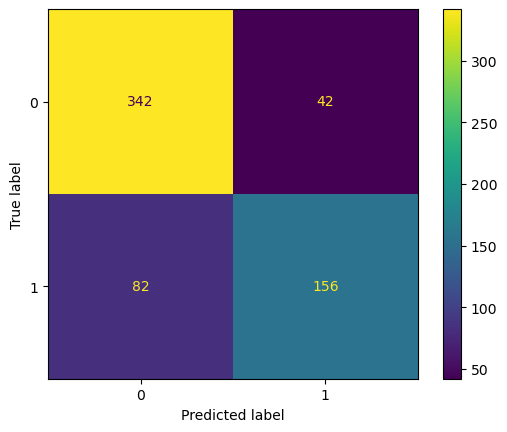

In [45]:
## making a confusion matrix for knn

plot_confusion_matrix(knn10, X_train, y_train)


In [46]:
# making y predictions on X_train dataset,
# to allow for the confusion_matrix to be realised

y_preds10 = knn10.predict(X_train)


In [47]:
# returning the confusion matrix as an array

confu10 = confusion_matrix(y_preds10, y_train)
confu10


array([[342,  82],
       [ 42, 156]])

In [48]:
# unravelling the confusion matrix & assigning each value to a variable

TN10, FP10, FN10, TP10 = confu10.ravel()

TN10, FP10, FN10, TP10


(342, 82, 42, 156)

In [49]:
print(classification_report(y_train, y_preds10))

# classification report on the training dataset

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       384
           1       0.79      0.66      0.72       238

    accuracy                           0.80       622
   macro avg       0.80      0.77      0.78       622
weighted avg       0.80      0.80      0.80       622



In [50]:
# Accuracy

print(f'The accuracy is {sklearn.metrics.accuracy_score(y_train, y_preds10)}.')


The accuracy is 0.8006430868167203.


In [51]:
# sensitivity / true positive rate / recall

print(f'The recall is {sklearn.metrics.recall_score(y_train, y_preds10, average = None)}.')

The recall is [0.890625   0.65546218].


In [52]:
# false negative rate

print(f'The false negative rate is {round(FN10 / (TP10 + FN10), 4)}).')

The false negative rate is 0.2121).


In [53]:
# precision / PPV

print(f'The precision rate is {sklearn.metrics.precision_score(y_train, y_preds10, average = None)}.')

The precision rate is [0.80660377 0.78787879].


In [54]:
# support

support_pos10 = TP10 + FN10 ## positive cases
support_neg10 = FP10 + TN10 ## negative cases

support_pos10, support_neg10, y_train.value_counts()

(198,
 424,
 0    384
 1    238
 Name: survived, dtype: int64)

In [55]:
# support

print(f'The support is {sklearn.metrics.precision_recall_fscore_support(y_train, y_preds10, average = None)}.')

The support is (array([0.80660377, 0.78787879]), array([0.890625  , 0.65546218]), array([0.84653465, 0.71559633]), array([384, 238])).


In [56]:
# f1 score

print(f'The f1 score is {sklearn.metrics.f1_score(y_train, y_preds10, average = None)}.')

The f1 score is [0.84653465 0.71559633].


In [57]:
## NVP / negative predicted value
print(f'The negative predicted value is {TN10 / (TN10 + FN10)}.')

The negative predicted value is 0.890625.
